In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from pathlib import Path
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120


Cell 2 — Paths (as you provided)

In [3]:
PATHS = {
    "LOSF": Path("/content/drive/MyDrive/VLM_project/metrics/losf_metrics_train_debug_k5_beta1_limit300.json"),
    "ETA-prefix": Path("/content/drive/MyDrive/VLM_project/Copy of eta_prefix_metrics_train_debug.json"),
    "LEACE": Path("/content/drive/MyDrive/VLM_project/leace_results_hm_500_k5.json"),
    "SAFE-clip": Path("/content/drive/MyDrive/VLM_project/safe_clip_metrics_train_clean.json"),
}

for name, p in PATHS.items():
    print(f"{name:10s} exists? {p.exists()}  -> {p}")


LOSF       exists? True  -> /content/drive/MyDrive/VLM_project/metrics/losf_metrics_train_debug_k5_beta1_limit300.json
ETA-prefix exists? True  -> /content/drive/MyDrive/VLM_project/Copy of eta_prefix_metrics_train_debug.json
LEACE      exists? True  -> /content/drive/MyDrive/VLM_project/leace_results_hm_500_k5.json
SAFE-clip  exists? True  -> /content/drive/MyDrive/VLM_project/safe_clip_metrics_train_clean.json


Cell 3 — Robust JSON loader

(Handles both pure JSON and logs + JSON files)

In [4]:
def load_metrics_json(path: Path) -> dict:
    # Try normal JSON first
    try:
        with open(path, "r") as f:
            return json.load(f)
    except Exception:
        pass

    # Fallback: extract last {...} JSON blob
    text = path.read_text(encoding="utf-8", errors="ignore")
    matches = re.findall(r"\{.*\}", text, flags=re.DOTALL)
    if not matches:
        raise ValueError(f"No JSON object found in {path}")
    return json.loads(matches[-1])


Cell 4 — Load all methods into one table

In [5]:
metrics_by_method = {
    name: load_metrics_json(p)
    for name, p in PATHS.items()
}

df = pd.DataFrame.from_dict(metrics_by_method, orient="index")
df.index.name = "method"

# Optional: reorder important columns first
preferred_cols = [
    "utility_recall@k_pre_S_V", "utility_recall@k_post_S_V",
    "harmful_recall@k_pre_U_V", "harmful_recall@k_post_U_V",
    "clipscore_safe_pre", "clipscore_safe_post",
]

df = df[[c for c in preferred_cols if c in df.columns] +
        [c for c in df.columns if c not in preferred_cols]]

df


,utility_recall@k_pre_S_V,utility_recall@k_post_S_V,harmful_recall@k_pre_U_V,harmful_recall@k_post_U_V,clipscore_safe_pre,clipscore_safe_post,text_semantic_shift_decline_to_unsafe,text_semantic_shift_increase_to_neutral,safety_rates_ASR,safety_rates_USR
method,,,,,,,,,,
LOSF,0.855263,0.833333,0.888889,0.833333,0.333297,0.333375,0.000000,0.000000,None,None
ETA-prefix,0.855263,0.771930,0.888889,0.847222,0.333297,0.282199,0.032145,-0.055104,None,None
LEACE,0.873016,0.873016,0.935185,0.935185,0.260540,0.260386,-0.002201,0.002192,None,None
SAFE-clip,0.777506,0.468326,0.763990,0.393755,0.340852,0.186987,0.664642,-0.665107,None,None


Cell 5 — Unified pre vs post plot (grouped bars)

In [6]:
def plot_pre_post_all_methods(
    df: pd.DataFrame,
    metric_pre: str,
    metric_post: str,
    title: str,
    figsize=(7, 3.5),
):
    fig, ax = plt.subplots(figsize=figsize)

    methods = df.index.tolist()
    pre_vals = df[metric_pre].astype(float).values
    post_vals = df[metric_post].astype(float).values

    x = np.arange(len(methods))
    width = 0.38

    ax.bar(x - width / 2, pre_vals, width, label="pre")
    ax.bar(x + width / 2, post_vals, width, label="post")

    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=20, ha="right")
    ax.set_ylabel("value")
    ax.set_title(title)
    ax.legend()
    ax.grid(axis="y", linestyle=":", alpha=0.6)

    plt.tight_layout()
    plt.show()


Cell 6 — Unified comparison plots (main results)
Utility Recall@K (safe)

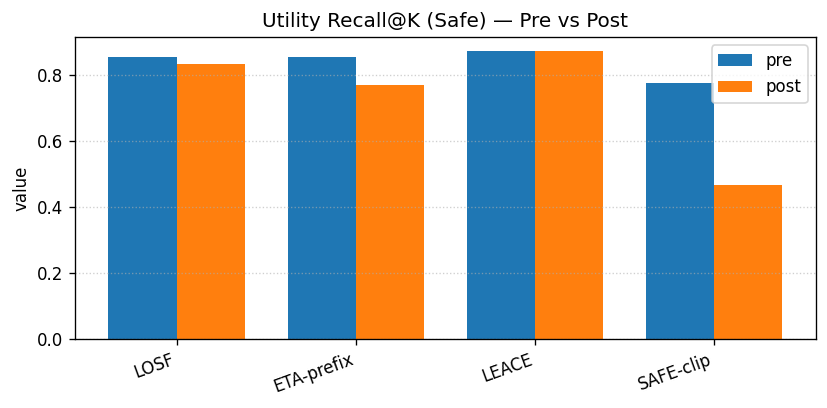

In [7]:
plot_pre_post_all_methods(
    df,
    "utility_recall@k_pre_S_V",
    "utility_recall@k_post_S_V",
    "Utility Recall@K (Safe) — Pre vs Post"
)


Harmful Recall@K (unsafe)

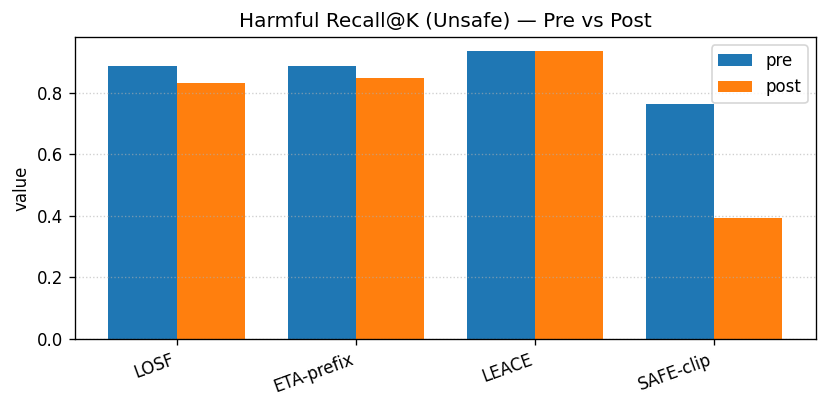

In [8]:
plot_pre_post_all_methods(
    df,
    "harmful_recall@k_pre_U_V",
    "harmful_recall@k_post_U_V",
    "Harmful Recall@K (Unsafe) — Pre vs Post"
)


CLIPScore (safe pairs)

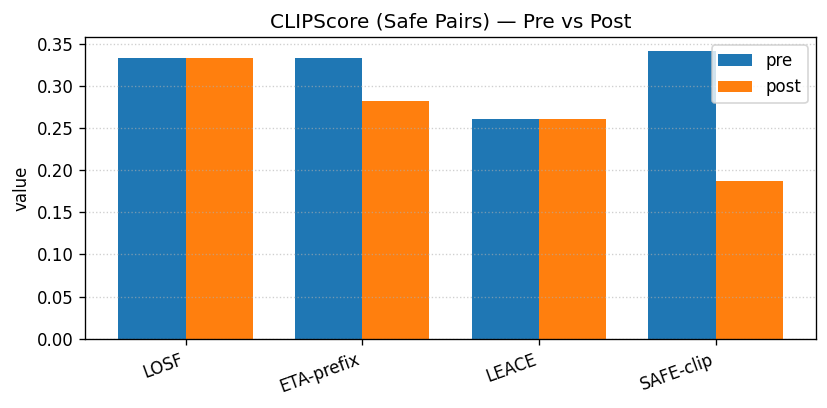

In [9]:
plot_pre_post_all_methods(
    df,
    "clipscore_safe_pre",
    "clipscore_safe_post",
    "CLIPScore (Safe Pairs) — Pre vs Post"
)


Cell 7 — (Optional but very useful) Δ plots (post − pre)

In [10]:
def plot_delta_all_methods(
    df: pd.DataFrame,
    metric_pre: str,
    metric_post: str,
    title: str,
    figsize=(7, 3.2),
):
    fig, ax = plt.subplots(figsize=figsize)

    methods = df.index.tolist()
    delta = df[metric_post].astype(float).values - df[metric_pre].astype(float).values

    x = np.arange(len(methods))
    ax.bar(x, delta)

    ax.axhline(0, linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=20, ha="right")
    ax.set_ylabel("Δ (post − pre)")
    ax.set_title(title)
    ax.grid(axis="y", linestyle=":", alpha=0.6)

    plt.tight_layout()
    plt.show()


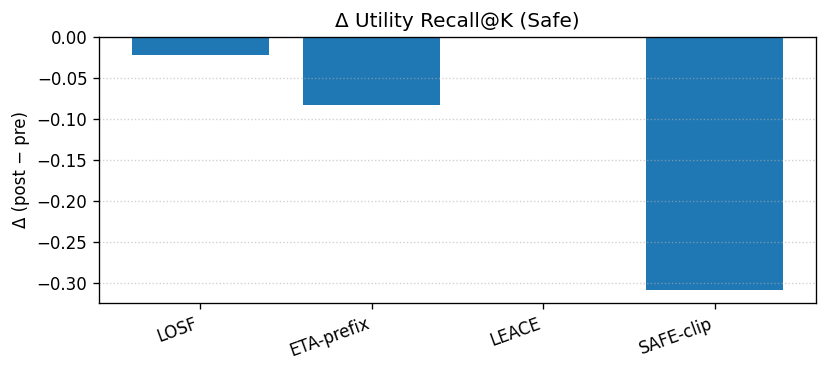

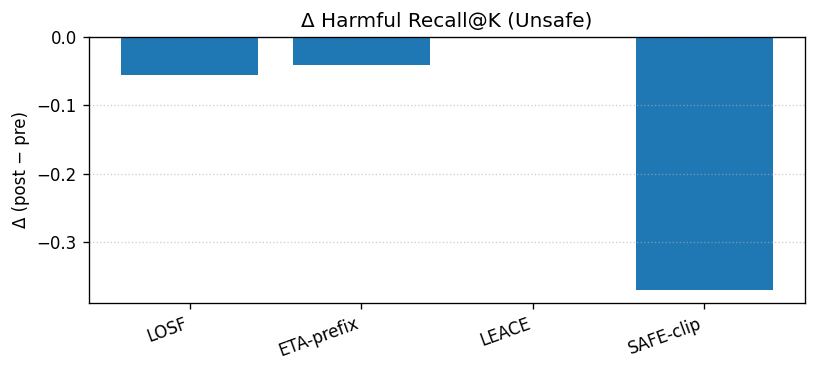

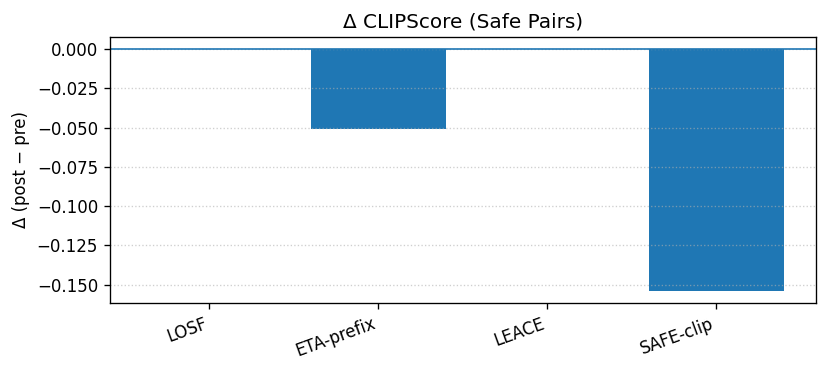

In [11]:
plot_delta_all_methods(
    df,
    "utility_recall@k_pre_S_V",
    "utility_recall@k_post_S_V",
    "Δ Utility Recall@K (Safe)"
)

plot_delta_all_methods(
    df,
    "harmful_recall@k_pre_U_V",
    "harmful_recall@k_post_U_V",
    "Δ Harmful Recall@K (Unsafe)"
)

plot_delta_all_methods(
    df,
    "clipscore_safe_pre",
    "clipscore_safe_post",
    "Δ CLIPScore (Safe Pairs)"
)
